# Flickr dataset + ViT Feature Extractor

In [1]:
from transformers import ViTModel
from PIL import Image

f:\__ing\llming_1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
MODEL = 'google/vit-base-patch16-224-in21k' 

vit_model = ViTModel.from_pretrained(MODEL)
vit_model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [6]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL)

feature_extractor

f:\__ing\llming_1\.venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

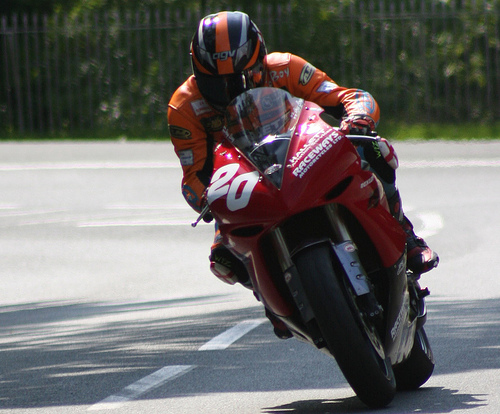

In [8]:
img = Image.open('./data/flicker_images/166321294_4a5e68535f.jpg')
display(img)

In [17]:
img_feats = feature_extractor(img)['pixel_values'][0]
img_feats.shape

(3, 224, 224)

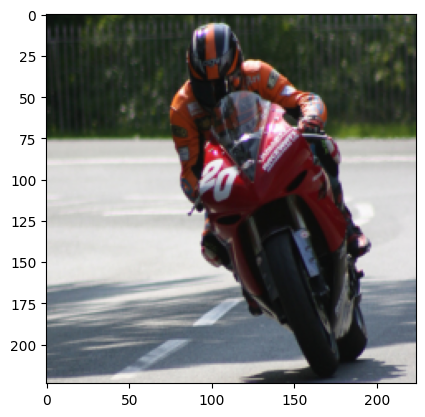

In [24]:
import matplotlib.pyplot as plt

plt.imshow((img_feats.transpose(1,2,0)+1)/2);

# Fine-tuning an image captioning system

In [1]:
from transformers import VisionEncoderDecoderModel, GPT2TokenizerFast, AutoFeatureExtractor, \
                AutoTokenizer, TrainingArguments, Trainer

from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import Dataset
import torch
from torch import numel
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize


import requests
from io import BytesIO

f:\__ing\llming_1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ENC_MODEL = 'WinKawaks/vit-small-patch16-224'
# 'google/vit-small-patch16-224-in21k' 
DEC_MODEL = 'distilgpt2'

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    ENC_MODEL, DEC_MODEL
)

Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.ln_cross_attn.bias', 'transformer.h.2.crossattention.c_attn.bias', 'transformer.h.2.crossattention.q_attn.bias', 'transformer.h.4.ln_cross_attn.weight', 'transformer.h.5.crossattention.c_proj.bias', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.5.crossattention.c_attn.weight', 'transformer.h.3.crossattention.c_proj.bias', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.3.crossattention.q_attn.bias', 'transformer.h.3.crossattention.c_attn.bias', 'transformer.h.1.crossattention.q_attn.

In [3]:
total_params = 0
for param in model.parameters():
    total_params += numel(param)

print(f"{total_params:,}")

118,205,184


In [4]:
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained(DEC_MODEL)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

In [5]:
IMAGES_PATH = os.path.join(os.getcwd(),'data','flicker_images')
MIN_CAPTION, MAX_CAPTION = 10, 50 #chars not words

def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []

        for line in caption_data:
            line = line.rstrip('\n')

            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times fol the five different captions. |
            # Each image name has a suffix “#(caption number)"
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH,img_name.strip())

            if img_name.endswith("jpg"):
                caption = caption.replace(' .', '').strip()
                tokens = caption.strip().split()
                if len(caption) < MIN_CAPTION or len(caption) > MAX_CAPTION:
                    continue
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]
        
        return caption_mapping, text_data
    
caption_mapping, text_data = load_captions_data('./data/Flickr8k.token.txt')

In [6]:
feature_extractor = AutoFeatureExtractor.from_pretrained(ENC_MODEL)

f:\__ing\llming_1\.venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
normalize = Normalize(
    mean=feature_extractor.image_mean,
    std=feature_extractor.image_std
)

_transforms = Compose(
    [
        RandomResizedCrop(list(feature_extractor.size.values())), # Data augmentation by taking random crops
        ToTensor(),
        normalize
    ]
)

In [8]:
rows = []

for path, captions in caption_mapping.items():
    for caption in captions:
        rows.append(
            {'path':path, 'caption':caption}
        )

image_df = pd.DataFrame(rows)
image_dataset = Dataset.from_pandas(image_df.sample(frac=0.3))
image_dataset = image_dataset.remove_columns('__index_level_0__')

image_dataset

Dataset({
    features: ['path', 'caption'],
    num_rows: 5880
})

In [9]:
def image_preprocess(examples):
    examples['pixel_values'] = [_transforms(Image.open(path)) for path in examples['path']]

    tokenized = gpt2_tokenizer(
        examples['caption'], padding='max_length', max_length=10, truncation=True
    )['input_ids']

    examples['labels'] = [
        [l if l!=gpt2_tokenizer.pad_token_id else -100 for l in t] for t in tokenized
    ] # shift is done internally, no need to shift

    del examples['path']
    del examples['caption']
    return examples

In [10]:
image_dataset = image_dataset.map(image_preprocess, batched=True)
image_dataset = image_dataset.train_test_split(test_size=.1)
image_dataset

Map: 100%|██████████| 5880/5880 [01:06<00:00, 88.11 examples/s]


DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 5292
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 588
    })
})

In [11]:
model.config.pad_token = gpt2_tokenizer.pad_token
model.config.pad_token_id = gpt2_tokenizer.pad_token_id

model.config.decoder_start_token = gpt2_tokenizer.bos_token
model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id

In [12]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [13]:
for name, param in model.encoder.named_parameters():
    if 'encoder.layer.10' in name:
        break
    param.requires_grad = False


# for name, param in model.decoder.named_parameters():    
#     if 'transformer.h.4' in name:
#         break
#     param.requires_grad = False

In [14]:
total_params = 0
total_trainable_params = 0

for _,param in model.named_parameters():
    total_params += 1
    total_trainable_params += param.requires_grad


print(f"Model trainable params percentage: {total_trainable_params/total_params*100:.2f}%")

Model trainable params percentage: 49.69%


In [15]:
training_args = TrainingArguments(
    output_dir='./v2_image_captioning',
    overwrite_output_dir=True,
    num_train_epochs=4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    load_best_model_at_end=True,
    log_level='info',
    logging_steps=50,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=image_dataset['train'],
    eval_dataset=image_dataset['test']
)

trainer.evaluate()

***** Running Evaluation *****
  Num examples = 588
  Batch size = 64
100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


{'eval_loss': 5.093921661376953,
 'eval_runtime': 100.1582,
 'eval_samples_per_second': 5.871,
 'eval_steps_per_second': 0.1}

In [16]:
trainer.train()

***** Running training *****
  Num examples = 5,292
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 332
  Number of trainable parameters = 100,089,216
 15%|█▌        | 50/332 [05:28<30:17,  6.44s/it] 

{'loss': 3.6758, 'learning_rate': 4.2469879518072294e-05, 'epoch': 0.6}


 25%|██▌       | 83/332 [08:53<17:48,  4.29s/it]***** Running Evaluation *****
  Num examples = 588
  Batch size = 64
                                                
 25%|██▌       | 83/332 [09:48<17:48,  4.29s/it]Saving model checkpoint to ./v2_image_captioning\checkpoint-83
Configuration saved in ./v2_image_captioning\checkpoint-83\config.json


{'eval_loss': 2.9513823986053467, 'eval_runtime': 55.137, 'eval_samples_per_second': 10.664, 'eval_steps_per_second': 0.181, 'epoch': 1.0}


Configuration saved in ./v2_image_captioning\checkpoint-83\generation_config.json
Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading
Model weights saved in ./v2_image_captioning\checkpoint-83\pytorch_model.bin
 30%|███       | 100/332 [11:56<25:12,  6.52s/it] 

{'loss': 3.0733, 'learning_rate': 3.4939759036144585e-05, 'epoch': 1.2}


 45%|████▌     | 150/332 [17:18<19:20,  6.38s/it]

{'loss': 2.8661, 'learning_rate': 2.7409638554216873e-05, 'epoch': 1.81}


 50%|█████     | 166/332 [18:53<11:54,  4.30s/it]***** Running Evaluation *****
  Num examples = 588
  Batch size = 64
                                                 
 50%|█████     | 166/332 [19:47<11:54,  4.30s/it]Saving model checkpoint to ./v2_image_captioning\checkpoint-166


{'eval_loss': 2.8149750232696533, 'eval_runtime': 54.4576, 'eval_samples_per_second': 10.797, 'eval_steps_per_second': 0.184, 'epoch': 2.0}


Configuration saved in ./v2_image_captioning\checkpoint-166\config.json
Configuration saved in ./v2_image_captioning\checkpoint-166\generation_config.json
Model weights saved in ./v2_image_captioning\checkpoint-166\pytorch_model.bin
 60%|██████    | 200/332 [23:42<14:03,  6.39s/it]  

{'loss': 2.7239, 'learning_rate': 1.9879518072289157e-05, 'epoch': 2.41}


 75%|███████▌  | 249/332 [28:48<05:55,  4.28s/it]***** Running Evaluation *****
  Num examples = 588
  Batch size = 64
                                                 
 75%|███████▌  | 249/332 [29:43<05:55,  4.28s/it]

{'eval_loss': 2.765254259109497, 'eval_runtime': 55.1078, 'eval_samples_per_second': 10.67, 'eval_steps_per_second': 0.181, 'epoch': 3.0}


Saving model checkpoint to ./v2_image_captioning\checkpoint-249
Configuration saved in ./v2_image_captioning\checkpoint-249\config.json
Configuration saved in ./v2_image_captioning\checkpoint-249\generation_config.json
Model weights saved in ./v2_image_captioning\checkpoint-249\pytorch_model.bin
 75%|███████▌  | 250/332 [30:10<37:36, 27.52s/it]

{'loss': 2.6499, 'learning_rate': 1.2349397590361447e-05, 'epoch': 3.01}


 90%|█████████ | 300/332 [35:30<03:25,  6.42s/it]

{'loss': 2.538, 'learning_rate': 4.819277108433735e-06, 'epoch': 3.61}


100%|██████████| 332/332 [38:46<00:00,  4.28s/it]***** Running Evaluation *****
  Num examples = 588
  Batch size = 64
                                                 
100%|██████████| 332/332 [39:41<00:00,  4.28s/it]Saving model checkpoint to ./v2_image_captioning\checkpoint-332
Configuration saved in ./v2_image_captioning\checkpoint-332\config.json
Configuration saved in ./v2_image_captioning\checkpoint-332\generation_config.json


{'eval_loss': 2.757439374923706, 'eval_runtime': 54.8917, 'eval_samples_per_second': 10.712, 'eval_steps_per_second': 0.182, 'epoch': 4.0}


Model weights saved in ./v2_image_captioning\checkpoint-332\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./v2_image_captioning\checkpoint-332 (score: 2.757439374923706).
There were missing keys in the checkpoint model loaded: ['decoder.lm_head.weight'].
100%|██████████| 332/332 [39:57<00:00,  7.22s/it]

{'train_runtime': 2397.8128, 'train_samples_per_second': 8.828, 'train_steps_per_second': 0.138, 'train_loss': 2.8876895444938935, 'epoch': 4.0}


TrainOutput(global_step=332, training_loss=2.8876895444938935, metrics={'train_runtime': 2397.8128, 'train_samples_per_second': 8.828, 'train_steps_per_second': 0.138, 'train_loss': 2.8876895444938935, 'epoch': 4.0})

In [17]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 588
  Batch size = 64
100%|██████████| 10/10 [00:43<00:00,  4.37s/it]


{'eval_loss': 2.757439374923706,
 'eval_runtime': 55.5665,
 'eval_samples_per_second': 10.582,
 'eval_steps_per_second': 0.18,
 'epoch': 4.0}

In [18]:
trainer.save_model()

Saving model checkpoint to ./v2_image_captioning
Configuration saved in ./v2_image_captioning\config.json
Configuration saved in ./v2_image_captioning\generation_config.json
Model weights saved in ./v2_image_captioning\pytorch_model.bin


In [19]:
finetuned_model = VisionEncoderDecoderModel.from_pretrained('./v2_image_captioning')

loading configuration file ./v2_image_captioning\config.json


Model config VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "distilgpt2",
    "_num_labels": 1,
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0"
    },
    "initializer_range": 0.02,
    "is_decoder": true,
    "is_encoder_decoder": false,
    "label2id": {
      "LABEL_0

In [20]:
inference_transforms = Compose(
    [
        Resize(list(feature_extractor.size.values())),
        ToTensor(),
        normalize
    ]
)

In [21]:
# a helper function to caption images from the web or a file path
def caption_image(m, path):
    if 'http' in path:
        response = requests.get (path)
        img = Image.open (BytesIO(response.content))
        image_matrix = inference_transforms(img).unsqueeze(0)
    else:
        img = Image.open (path)
        image_matrix = inference_transforms(img).unsqueeze(0)

    generated = m.generate(
        image_matrix,
        num_beams=3,
        max_length=15,
        early_stopping=True,
        do_sample=True,
        top_k=10,
        num_return_sequences=3,
    )

    caption_options = [gpt2_tokenizer.decode(g, skip_special_tokens=True).strip() for g in generated]
    display (img)

    return caption_options, generated, image_matrix

Generate config GenerationConfig {
  "decoder_start_token_id": 50256,
  "pad_token_id": 50256
}

f:\__ing\llming_1\.venv\lib\site-packages\transformers\generation\utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


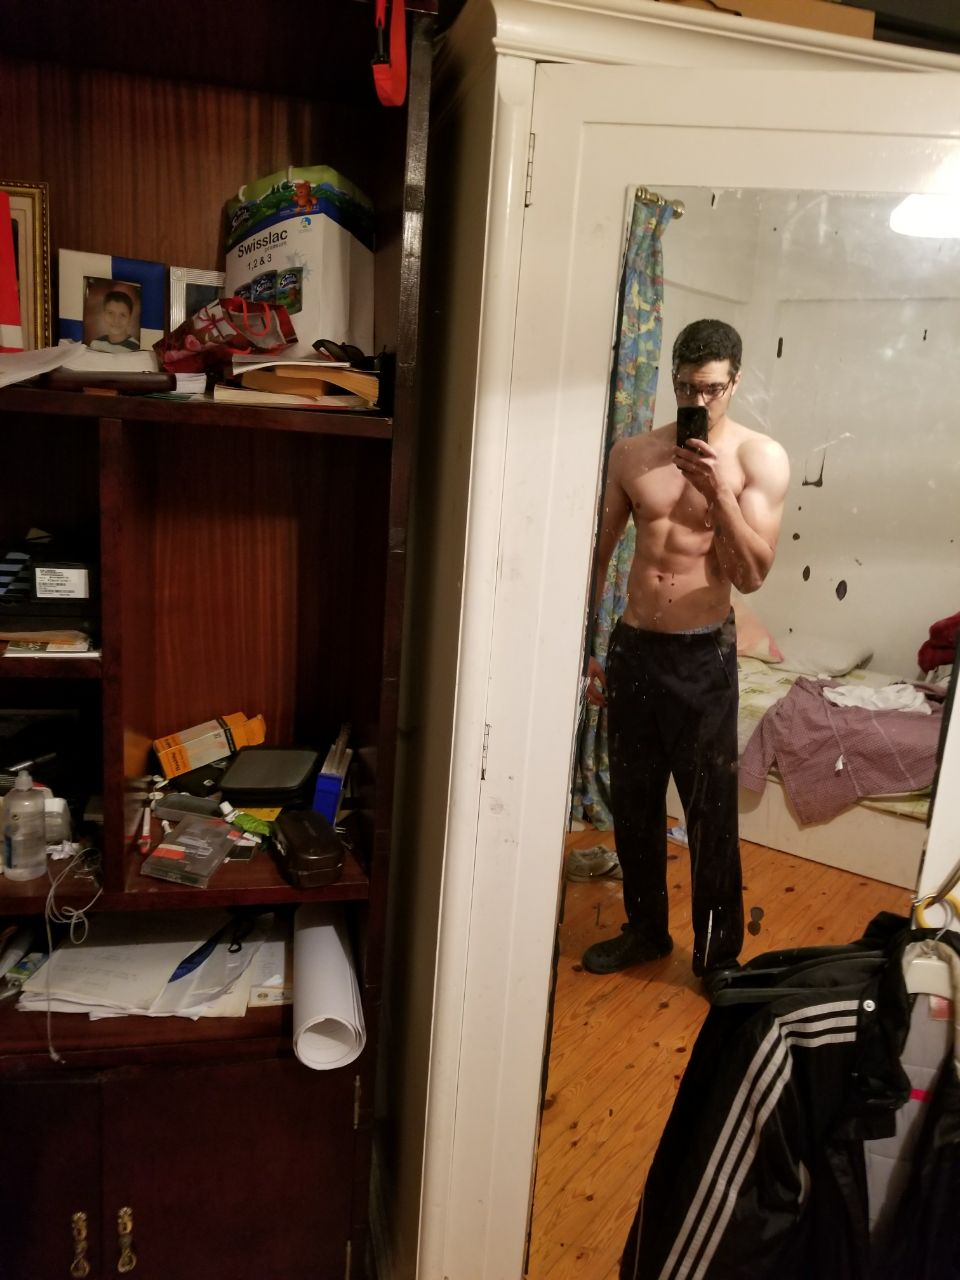

In [22]:
captions, generated, image_matrix = caption_image(finetuned_model, "F:\\__ing\\llming_1\\data\\IMG-20180104-WA0012.jpg")

In [23]:
captions

['A man in a blue shirt is holding a camera in his mouth while',
 'A man in a blue shirt is sitting on a bench in a building',
 'A man in a blue shirt is holding a camera in his mouth as']